# Convolutional NN from scratch
Train a deep neural network. Your network should work with different architecture parameters (number of layers, number of neurons on each layer, convolution window width, etc.) Try to find the best combination of parameters. Print confusion matrix heatmap as the result.

This model features a basic variable CNN supported by a fully conncected Layer at the end.
The model operates on the MNIST dataset and includes a dataloader for it. 

Certain restrictions were placed on the model: 
 - filter stepsize = 1
 - only 1 channel
 - 2 dimensional input (black white pictures) 
 - Quadratic filters (So there is no need for Padding)
 
Certain features are included: 
 - variable Number of convolutional and maxpooling layers
 - variable con and max layer sizes
 - Variable fully conncected head (size and hidden layers) 
 - data loader and saver for trained weights
 - Heat map and accuracy score for the results

In [482]:
from mlxtend.data import loadlocal_mnist
import math
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [500]:
class NN_MNIST:
        def __init__(self,structure,dimensions,hiddenLayers):
            self.load_data()
            self.CNN,self.bias_CNN, self.dim = \
            self.initialize_network_CNN(structure,dimensions)
            self.FC,self.bias_FC = self.initialize_FC(hiddenLayers)
            
        def load_data(self):  #loads MNIST data into useful format
            self.X, self.y = loadlocal_mnist(
                    images_path='./data/MNIST/train-images.idx3-ubyte',
                    labels_path='./data/MNIST/train-labels.idx1-ubyte')
            self.X = self.X /255
            self.X = self.X.reshape(60000,28,28)
            #self.X = self.X[:1000]
            #self.y = self.y[:1000]
            self.X_test, self.y_test = loadlocal_mnist(
                    images_path='./data/MNIST/t10k-images.idx3-ubyte',
                    labels_path='./data/MNIST/t10k-labels.idx1-ubyte')
            self.X_test = self.X_test /255
            self.X_test = self.X_test.reshape(len(self.X_test),28,28)  #normalization step based on max pixel value
            #self.X_test = self.X_test[:1000]
            #self.y_test = self.y_test[:1000]
            self.input = self.X[0].shape
            self.output = 10
            self.sizeX = self.X.shape[0]
            self.sizeY = self.y.shape[0]
            
        def initialize_network_CNN(self,structure,dimensions):#CNN weight initialization
            network = {}
            current = 28
            dims = []
            bias = {}
            for x in range (len(structure)):
                network[x] = [structure[x],np.random.normal(0,0.1,(dimensions[x],dimensions[x]))]
                current = current-dimensions[x]+1
                dims.append(current)  
                if structure[x] == "con":
                    bias[x] = 0
                else:
                    bias[x] = None
            return network,bias,dims
        
        def initialize_FC(self,hiddenLayers):   #FC weight initialization
            weights = {}
            bias = {}
            if len(hiddenLayers) > 0:
                if len(self.dim) > 0:
                    weights[0] = np.random.normal(0,0.1,(hiddenLayers[0], self.dim[-1]**2))
                else: 
                    weights[0] = np.random.normal(0,0.1,(hiddenLayers[0], 784))
                bias[0] = np.random.normal(0,0.1,(hiddenLayers[0], 1))
                for x in range(1,len(hiddenLayers)):
                    weights[x] =  np.random.normal(0,0.1,(hiddenLayers[x], hiddenLayers[x-1]))
                    bias[x] =  np.random.normal(0,0.1,(hiddenLayers[x], 1))
                weights[len(hiddenLayers)] =  np.random.normal(0,0.1,(10, hiddenLayers[len(hiddenLayers)-1]))
                bias[len(hiddenLayers)] =  np.random.normal(0,0.1,(10, 1))
            else:
                if len(self.dim) > 0:
                    weights[len(hiddenLayers)] =  np.random.normal(0,0.1,(10, self.dim[-1]**2))
                else:
                    weights[len(hiddenLayers)] =  np.random.normal(0,0.1,(10, 784))
                bias[len(hiddenLayers)] =  np.random.normal(0,0.1,(10, 1))
            return weights,bias
        
        def relu(self,Z):    #Activation and loss functions
            return np.where(Z<0,0.01*Z,Z)
        
        def relu_dev(self,x):
            x = np.array(x)
            return np.where(x<0,0.01,1)
        
        def softmax(self,X):
            X = X - max(X)
            return np.divide(np.exp(X),np.sum( np.exp(X),keepdims = True))
            
        def convolution(self,img,depth):       #convolution step for one layer and picture
            f_size = len(self.CNN[depth][1]) 
            result = np.zeros((self.dim[depth],self.dim[depth]))
            for x in range(self.dim[depth]):
                for y in range(self.dim[depth]):
                    out = (img[x:x+f_size,y:y+f_size]) * (self.CNN[depth][1])
                    out = np.sum(out)
                    out = out + self.bias_CNN[depth] #single bias shared over complete feature map! 
                    result[x][y] = out
            out = self.relu(result)
            return out, result
        
        def downsampling(self,img,depth): #downsampling step for single layer and picture
            f_size = len(self.CNN[depth][1]) # filter dimensions
            result = np.zeros((self.dim[depth],self.dim[depth]))
            for x in range(self.dim[depth]):
                for y in range(self.dim[depth]):
                    out = img[x:x+f_size,y:y+f_size]
                    out = np.max(out)
                    result[x][y] = out
            return (result)
        
        def fully_connected(self,out):  #Forward path for all FC layers
            caches = []
            for x in range (len(self.FC)-1):
                cache = []
                out = np.dot(self.FC[x],out) + self.bias_FC[x]
                cache.append(out)
                out = self.relu(out)
                cache.append(out)
                caches.append(cache)
            cache = []
            out = np.dot(self.FC[len(self.FC)-1],out) + self.bias_FC[len(self.FC)-1]
            cache.append(out)
            out = self.softmax(out)
            cache.append(out)
            caches.append(cache)
            return out, caches
            
        def forward(self,img):  #forward propagation for 1 picture 
            current = img
            caches = []
            caches.append([[],img])
            for x in range(len(self.dim)):
                if self.CNN[x][0] == "con":
                    current, cache = self.convolution(current,x)
                    caches.append([current,cache])
                else:
                    current = self.downsampling(current,x)
                    caches.append([[],current])
            current = current.reshape(len(current)**2,1)
            caches.append(current)
            result,cache = self.fully_connected(current)
            caches.append(cache)
            return result.T[0],np.array(caches)
        
        def predict(self,what):    #predict the training or testing data
            predictions = []
            if what == "train":
                for x in range (len(self.X)):
                    out, cache = self.forward(self.X[x])
                    out = np.argmax(out)
                    predictions.append(out)
            elif what == "test":
                for x in range (len(self.X_test)):
                    out, cache = self.forward(self.X_test[x])
                    out = np.argmax(out)
                    predictions.append(out)
            return predictions
        
        def evaluate(self,what):   #compare predictions with actual labels
            predictions = self.predict(what)
            if what == "train":
                CM = self.confusion_matrix(self.y,predictions)
                print("The accuracy of the model is : " + str(self.accuracy(self.y,predictions))+"%")
            elif what == "test":
                CM = self.confusion_matrix(self.y_test,predictions)
                print("The accuracy of the model is : " + str(self.accuracy(self.y_test,predictions))+"%")
            df_cm = pd.DataFrame(CM, index = [i for i in "0123456789"],columns = [i for i in "0123456789"])
            plt.figure(figsize = (10,7))
            ax = plt.axes()
            ax.set_title('True Labels = Rows, Predictions = Columms')
            sn.set(font_scale=1)
            sn.heatmap(df_cm, annot=True,cbar = False)

        def confusion_matrix(self,labels,preds):   #metrics and helper functions
            confusion = np.zeros((self.output,self.output))
            for x in range(len(preds)):
                confusion[int(labels[x])][int(preds[x])] +=1
            return confusion
        
        def accuracy(self,labels,preds):
            return (np.count_nonzero(np.equal(labels,preds))) / len(labels) *100 
        
        def oneHotEncoding(self,label):
            encode = np.zeros((self.output,1))
            encode[label] = 1
            return encode
        
        def backward(self,cache,lr,index):   #full backpropagation for 1 picture
            dOut = self.backward_FC(cache,lr,index)
            if len(self.CNN) > 0: 
                dOut = dOut.reshape(self.dim[-1],self.dim[-1])
                self.backward_CNN(cache,lr,dOut)
        
        def cross_entropy(self,pred,label):   #loss function
            return - math.log(pred[label]+0.00000000000001)
        
        def backward_CNN(self,cache,lr,gradient):   #conv part backward prob
            dWs = []
            dBs = []
            cache = cache[:len(self.dim)+1]
            for w in range(len(self.dim)):
                x = len(self.CNN)-1-w
                f = len(self.CNN[x][1])
                if self.bias_CNN[x] == None:
                    dX = np.zeros((len(cache[x][1]),len(cache[x][1])))
                    for z in range(f):
                        for y in range(f):
                            window = cache[x][1][z:z+f,y:y+f]
                            dX[z:z+f,y:y+f] += np.where(window \
                            == np.max(window),gradient[z][y],0)
                    dWs.append("NG")
                    gradient = dX
                else:
                    dZ = gradient * self.relu_dev(cache[x+1][0])
                    dW = np.zeros((f,f))
                    dX = np.zeros((len(cache[x][1]),len(cache[x][1])))
                    for z in range(f):
                        for y in range(f):
                            dW += (cache[x][1][z:z+f,y:y+f]) * dZ[z][y]
                            dX[z:z+f,y:y+f] += self.CNN[x][1] * dZ[z][y]
                    dWs.append(dW/(f**2))
                    gradient = dX       
            for y in range(len(dWs)): 
                if not isinstance(dWs[len(dWs)-1-y],str) :
                    self.CNN[y][1] = self.CNN[y][1]- dWs[len(dWs)-1-y]
                     
        def backward_FC(self,cache,lr,index):  #FC backward prob
            result = cache[len(cache)-2]
            cache = cache[len(cache)-1]
            dWs = []
            dBs = []
            y = self.oneHotEncoding(self.y[index])
            if len(self.FC)>1:
                dZ = cache[len(cache)-1][1] - y
                dW = np.dot(dZ, cache[len(cache)-2][1].T)
                dB = np.sum(dZ, axis=1, keepdims=True)
                dWs.append( lr * dW)
                dBs.append( lr * dB)
                for x in range (len(cache)-1,1,-1):
                    dZ = np.dot(self.FC[x].T,dZ)*self.relu_dev(cache[x-1][0])
                    dW = np.dot(dZ, cache[x-2][1].T)
                    dB = np.sum(dZ, axis=1, keepdims=True)
                    dWs.append( lr * dW)
                    dBs.append( lr * dB)
                dZ = np.dot(self.FC[1].T,dZ)*self.relu_dev(cache[0][0])
                dW = np.dot(dZ, result.T)
                dB = np.sum(dZ, axis=1, keepdims=True)
                dWs.append( lr * dW)
                dBs.append( lr * dB)
                dOut = np.dot(self.FC[0].T,dZ)
            else: 
                dZ = cache[len(cache)-1][1] - y
                dW = np.dot(dZ, result.T)
                dB = np.sum(dZ, axis=1, keepdims=True)
                dOut = np.dot(self.FC[0].T,dZ)
                dWs.append( lr * dW)
                dBs.append( lr * dB)
            for y in range(len(dWs)): 
                self.FC[y] = self.FC[y]- dWs[len(dWs)-1-y]
                self.bias_FC[y] = self.bias_FC[y] - dBs[len(dWs)-1-y]
            return dOut
        
        def train(self,lr,epochs):     #Train with stochastic gradient descent
            for x in range(epochs):
                Loss = 0
                for y in range (len(self.X)):
                    result,cache = self.forward(self.X[y])
                    Loss += self.cross_entropy(result,self.y[y])
                    self.backward(cache,lr,y)
                print(Loss/self.sizeX)          
        
        def save_weights(self,location):  #save your weights or load preloaded weights
            pickle_out = open(location  + "/weights_CNN.pickle","wb")
            pickle.dump(self.CNN, pickle_out)
            pickle_out.close()
            pickle_out = open(location  + "/bias_CNN.pickle","wb")
            pickle.dump(self.bias_CNN, pickle_out)
            pickle_out.close()
            pickle_out = open(location  + "/weights_FC.pickle","wb")
            pickle.dump(self.FC, pickle_out)
            pickle_out.close()
            pickle_out = open(location  + "/bias_FC.pickle","wb")
            pickle.dump(self.bias_FC, pickle_out)
            pickle_out.close()
            pickle_out = open(location  + "/dim.pickle","wb")
            pickle.dump(self.dim, pickle_out)
            pickle_out.close()

        def load_weights(self,location):
            pickle_in = open(location  + "/bias_CNN.pickle","rb")
            self.bias_CNN = pickle.load(pickle_in)
            pickle_in = open(location  + "/weights_CNN.pickle","rb")
            self.CNN = pickle.load(pickle_in)
            pickle_in = open(location  + "/bias_FC.pickle","rb")
            self.bias_FC = pickle.load(pickle_in)
            pickle_in = open(location  + "/weights_FC.pickle","rb")
            self.FC = pickle.load(pickle_in)
            pickle_in = open(location  + "/dim.pickle","rb")
            self.dim = pickle.load(pickle_in)
            
                

In [501]:
NN = NN_MNIST(["con","max"],[5,5],[50])
NN.load_weights("pretrain_cnn_2")





2.2528871067843483
0.7830216644162621
0.6500680070695086
0.5760206640561728
0.5386987393197477
0.5087028113334093
0.48451219996263045
0.46267508916187705
0.4426800733145286
0.4267353650332424


In [504]:
NN.train(0.05,10)


0.34291358170494657
0.33749050318539936
0.33167714170298523
0.32785125738964865
0.32493050859904465
0.3198583994661026
0.3163459035573342
0.31639734315094864


KeyboardInterrupt: 

The accuracy of the model is : 89.95%


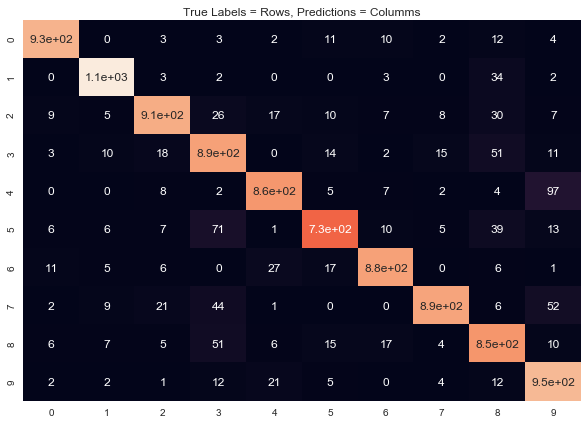

In [507]:
NN.evaluate("test")

In [ ]:
def optimizer(data,maxFC,maxCNN,maxSIZE):
    if data == "MNIST":
        best = 0
        bestModel = None
        for x in range(len(maxFC)):
            for y in range(len(maxCNN)):
                NN = NN_MNIST([:len(maxCNN)-y],[:len(maxSIZE)-y],maxFC[:len(maxFC)-x])
                NN.train(0.01,50)
                result = NN.predict("test")
                accuracy = NN.accuracy(self.y_test,result)
                if accuracy > best:
                    bestModel = NN
        return model,accuracy
                
                
    

In [455]:
best,accuracy = optimizer("MNIST",["con","con","max"],[5,4,3],[50])

KeyError: 1